In [3]:
#%pip install -q ipywidgets
#%pip install -q ipympl

In [1]:
from sandboxlib import *

In [2]:
%matplotlib ipympl
plt.ioff()

## Das ABC der Abflussmodellierung

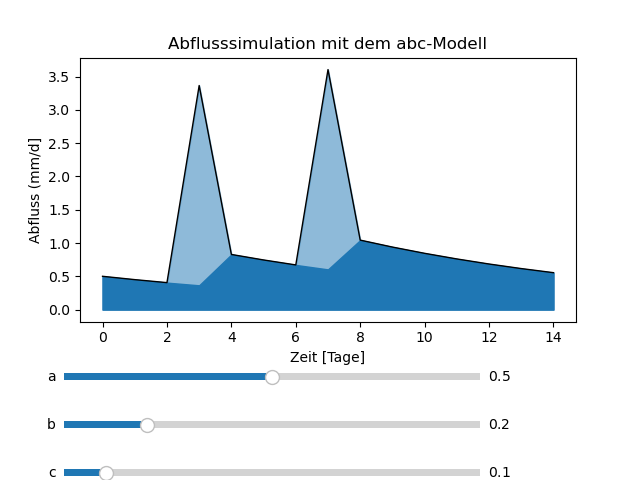

In [3]:
P = np.array([0,0,0,10,0,0,0,10,0,0,0,0,0,0,0])
sim = abc(P, 0.1, 0.1, 0.2)
plot_abc_model(P)

## Das USGS SCS-CN Verfahren (oder auch: Curve-Number-Verfahren)

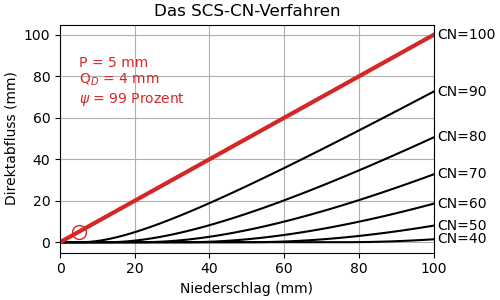

interactive(children=(Dropdown(description='Landnutzung', options=('Brache', 'Reihenkulturen', 'Getreide', 'Wi…

In [5]:
plot_cn()

## Modellierung der Infiltration mit dem Green-Ampt-Verfahren

In [2]:
#      
# Copyright (c) 2015, Peishi Jiang

#--------------------------------------------------------
# class GreenAmpt
#
#    __init__()
#    Fp
#    f
#    F
#    __EqnF
#    F_f
#
#--------------------------------------------------------
# This model is based on the Green-Ampt method described
# in <Applied Hydrology>, pp110.
# 
# Ref:
# Chow, Ven T., David R. Maidment, and Larry W. Mays. 
# Applied hydrology. 1988.
#--------------------------------------------------------

from scipy.optimize import newton
from pprint import pprint
from json import dump
from math import log
import numpy as np

class GreenAmpt(object):
    '''
    Green-Ampt Cumulative Infiltration 
    '''
        
    def __init__(self, K, dt, theta_i, theta_s, psi, i):
        """
        Constructor
        """
        self.K       = K                 # hydraulic conductivity
        self.dt      = dt                # time resolution
        self.theta_i = theta_i           # initial water content
        self.theta_s = theta_s           # saturated water content
        self.dtheta  = theta_s - theta_i # the change in the moisture content
        self.psi     = psi               # wetting front soil suction head
        if type(i) == list:
            self.i = i                   # rainfall intensity
        else:
            self.i = [i]
    
    def Fp(self, i):
        """
        Cumulative infiltration at the ponding time tp
        """
        return self.K * self.psi * self.dtheta / (i - self.K) 
    
    def F(self, F_t, dt_t):
        """
        Solve Equation of Green-Ampt Cumulative Infiltration __EqnF
        """
        F_t_next = lambda F: self.__EqnF(F_t, dt_t, F)
        return newton(F_t_next, 3)
    
    def f(self, F):
        """
        Generate Green-Ampt Infiltration Rate at time t
        """
        if F == 0:
            return -9999
        else:
            return self.K * (self.psi * self.dtheta / F + 1)    
        
    def __EqnF(self, F_t, dt_t, F):
        """
        Equation of Green-Ampt Cumulative Infiltration after ponding
        F:  Green-Ampt Cumulative Infiltration variable 
        """
        return F - F_t - self.K*dt_t - self.psi*self.dtheta*log((self.psi*self.dtheta+F)/(self.psi*self.dtheta+F_t))
    
    def F_f(self):
        """
        Generate the time series of cumulative infiltration and infiltration rate
        given the time series of rainfall intensity i
        """
        t_len = len(self.i)
        F_all = []; f_all = []; t_all = []
        # initial
        F_all.append(0)
        f_all.append(-9999)
        t_all.append(0)
        for ind in range(1, t_len+1):
            i_t = self.i[ind-1]
            f_t = f_all[ind-1]
            F_t = F_all[ind-1]
            if abs(f_t) <= i_t:
                # ponding occurs throught interval
                F_t_next = self.F(F_t, self.dt)
                f_t_next = self.f(F_t_next)
            elif abs(f_t) > i_t:
                # no ponding at the beginning of the interval
                F_t_next_temp = F_t + i_t*self.dt
                f_t_next_temp = self.f(F_t_next_temp)
                if abs(f_t_next_temp) > i_t:
                    # no ponding throughout interval
                    f_t_next = f_t_next_temp
                    F_t_next = F_t_next_temp
                elif abs(f_t_next_temp) <= i_t:
                    # ponding occurs during interval
                    Fp_t = self.Fp(i_t)
                    print (i_t)
                    dt_p = (Fp_t - F_t) / i_t
                    F_t_next = self.F(Fp_t, self.dt - dt_p)
                    f_t_next = self.f(F_t_next)        
            F_all.append(F_t_next)
            f_all.append(f_t_next)
            t_all.append(self.dt*(ind))        
        return F_all, f_all, t_all

In [8]:
import matplotlib.pyplot as plt

6.84


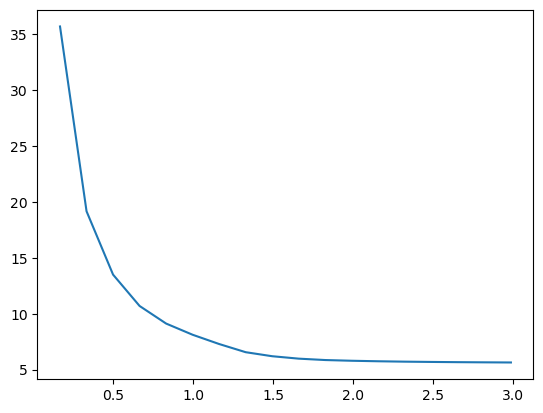

In [21]:
K = 5; psi = 11.01; thetai=0.3; thetas=0.4; dtheta = 0.247; dt = 0.166
i = [1.08, 1.26, 1.56, 1.92, 2.22, 2.58, 3.84, 6.84, 19.08, \
     9.90, 4.86, 3.12, 2.52, 2.16, 1.68, 1.44, 1.14, 1.02]
# K, dt, theta_i, theta_s, psi, i
a = GreenAmpt(K, dt, thetai, thetas, psi, i)
F, f, t =a.F_f()
#plt.plot(t, F)
plt.plot(t[1:], f[1:])

In [20]:
f

[-9999,
 35.706157965194116,
 19.172072907012673,
 13.503243744207602,
 10.698049931685507,
 9.12470778636936,
 8.122660132053639,
 7.293405989101636,
 6.562113403729621,
 6.201809989981397,
 5.984659389713856,
 5.86048891518867,
 5.796044129631137,
 5.75063755526489,
 5.715648319205668,
 5.69061070139708,
 5.67050368061918,
 5.655397265754571,
 5.642446585325759]

In [4]:
# def abc(P, a, b, c):
#     """Das abc-Modell
#     """
#     assert(a+b<=1)
#     assert(c<=1)
#     df = pd.DataFrame(columns=["P","Q","Qd","Qb"], index=np.arange(len(P)), dtype="float")
#     df["P"] = P
#     # Fuer den Grundwassspeicher G muessen wir einen Startwert annehmen.
#     G = 5.
#     # Ergebniscontainer fuer den Gesamtabfluss
#     Q = np.repeat(0.,len(P))
#     Gw = np.repeat(0.,len(P))
#     #G = np.repeat(0,len(P))
#     for i in range(len(P)):
#         df.loc[i,"Q"] = (1-a-b) * P[i] + c * G
#         df.loc[i,"Qd"] = (1-a-b) * P[i]
#         df.loc[i,"Qb"] = c * G
#         G = (1-c)*G + a*P[i]
#     return df
#     #return pd.DataFrame({"P":P, "Q":Q, "Qb":Qb, "Qd":Qd}, index=t)


In [7]:
# def plot_abc_model():
#     apar = 0.5
#     bpar = 0.2
#     cpar = 0.1
#     sim = abc(P, apar, bpar, cpar)
    
#     # Create the figure and the line that we will manipulate
#     fig, ax = plt.subplots(num=" ")
#     #fig.canvas.toolbar_position = 'bottom'
#     fillQ = plt.fill_between(t, sim.Q, color="tab:blue", alpha=0.5)
#     fillQb =plt.fill_between(t, sim.Qb, color="tab:blue", alpha=1.)
#     line, = ax.plot(t, sim.Q, lw=1, color="black")
#     ax.set_xlabel('Zeit [Tage]')
#     plt.ylabel("Abfluss (mm/d]")
#     plt.title("Abflusssimulation mit dem abc-Modell")
    
    
#     # adjust the main plot to make room for the sliders
#     fig.subplots_adjust(bottom=0.33)
    
#     # Make a horizontal slider to control a.
#     axa = fig.add_axes([0.1, 0.2, 0.65, 0.03])
#     a_slider = Slider(
#         ax=axa,
#         label='a',
#         valmin=0.,
#         valmax=1.,
#         valinit=apar,
#     )
    
#     # Make a horizontal slider to control b.
#     axb = fig.add_axes([0.1, 0.1, 0.65, 0.03])
#     b_slider = Slider(
#         ax=axb,
#         label='b',
#         valmin=0.,
#         valmax=1.,
#         valinit=bpar,
#     )
    
#     # Make a horizontal slider to control b.
#     axc = fig.add_axes([0.1, 0.0, 0.65, 0.03])
#     c_slider = Slider(
#         ax=axc,
#         label='c',
#         valmin=0.,
#         valmax=1.,
#         valinit=cpar,
#     )
    
#     # The function to be called anytime a slider's value changes
#     # def update(val):
#     #     line.set_ydata(abc(P, a_slider.val, b_slider.val, c_slider.val).Q)
#     #     fig.canvas.draw_idle()
    
#     def update(val): 
#         sim = abc(P, a_slider.val, b_slider.val, c_slider.val)
#         line.set_ydata(sim.Q)
#         #optional preventing autoscaling of y-axis 
#         ax.autoscale(False)
#         #create invisible dummy object to extract the vertices 
#         dummyQ = plt.fill_between(t, sim.Q , alpha=0)
#         dpQ = dummyQ.get_paths()[0]
#         dummyQ.remove()
#         fillQ.set_paths([dpQ.vertices])
        
#         dummyQb = plt.fill_between(t, sim.Qb , alpha=0)
#         dpQb = dummyQb.get_paths()[0]
#         dummyQb.remove()
#         #update the vertices of the PolyCollection
#         fillQb.set_paths([dpQb.vertices])
#         fig.canvas.draw_idle()
    
    
#     # register the update function with each slider
#     a_slider.on_changed(update)
#     b_slider.on_changed(update)
#     c_slider.on_changed(update)
    
#     # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
#     #resetax = fig.add_axes([0.8, -0.2, 0.1, 0.04])
#     #button = Button(resetax, 'Reset', hovercolor='0.975')
#     #def reset(event):
#     #    a_slider.reset()
#     #    b_slider.reset()
#     #    c_slider.reset()
#     #button.on_clicked(reset)
#     plt.show()